In [109]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x, y): return top_k_categorical_accuracy(x, y, 3)

tf.__version__

'1.14.0'

In [110]:
# Constants
BATCH_SIZE = 256
EPOCHS = 15
LABELS = [["SFGPUCA-----", "Friendly Armored"], ["SFGPUCF-----", "Friendly Artillery"], ["SFGPUCI-----", "Friendly Infantry"], 
          ["SFGPUCR-----", "Friendly Reconnaisance"], ["SHGPUCA-----", "Hostile Armored"], ["SHGPUCF-----", "Hostile Artillery"], 
          ["SHGPUCI-----", "Hostile Infantry"], ["SHGPUCR-----", "Hostile Reconnaisance"]]

for label in LABELS:
    print(label[1])

Friendly Armored
Friendly Artillery
Friendly Infantry
Friendly Reconnaisance
Hostile Armored
Hostile Artillery
Hostile Infantry
Hostile Reconnaisance


In [111]:
# Data extraction and visulization
df = pd.read_csv("symbolData/SymbolData.csv")
df.head()

,x,y,t,pixels,label,id
0,"684,658,632,616,585,548,514,483,460,446,438,43...","377,338,299,277,233,183,134,88,48,24,10,2,0,2,...","42,80,94,103,119,136,154,169,187,202,221,237,2...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",Hostile Armored,SHGPUCA-----
1,"696,695,693,683,671,646,606,564,522,481,440,40...","400,400,400,396,384,356,310,253,192,140,93,58,...","14,22,37,55,71,88,105,120,138,155,170,188,204,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",Hostile Armored,SHGPUCA-----
2,"136,130,129,124,121,118,110,106,98,94,85,82,79...","9,14,15,19,22,23,29,32,37,40,45,48,51,60,62,64...","45,60,72,74,82,90,98,106,114,122,130,138,147,1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",Hostile Infantry,SHGPUCI-----
3,"978,949,902,836,717,634,568,507,462,438,429,42...","592,562,515,451,332,233,155,82,35,9,1,0,0,3,10...","25,43,58,75,91,108,126,142,158,175,191,208,226...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",Hostile Armored,SHGPUCA-----
4,"157,155,154,151,147,145,139,136,132,129,127,12...","1,2,3,3,6,8,10,11,16,18,18,21,22,25,27,28,31,3...","6,23,31,39,47,56,64,72,80,89,96,104,112,120,12...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",Hostile Reconnaisance,SHGPUCR-----


In [112]:
df['pixels'] = df.pixels.apply(lambda x: x.split(','))
df['label'] = df.label.apply(lambda x: x.split(','))

del df['x']
del df['y']
del df['t']

df.head()

,pixels,label,id
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Hostile Armored],SHGPUCA-----
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Hostile Armored],SHGPUCA-----
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Hostile Infantry],SHGPUCI-----
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Hostile Armored],SHGPUCA-----
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Hostile Reconnaisance],SHGPUCR-----


In [113]:
df['target'] = df['id']

# Converting labels into uniqe numbers
for i, label_id in enumerate(df['id']):
    df['target'][i] = LABELS.index([label_id, *df['label'][i]])

half_len_pixel_array = int(len(df['pixels'][0])**(1/2))
    
# Normalizing pixel data
for i, array in enumerate(df['pixels']):
    for j, val in enumerate(array):
        df['pixels'][i][j] = int(val) / 255
    df['pixels'][i] = np.reshape(df['pixels'][i], (-1, half_len_pixel_array))
    
print(df['pixels'][0].shape)

(64, 64)


In [114]:
print(len(df['target']))
df.dropna(inplace=True)
print(len(df['target']))

df.head()

202
202


,pixels,label,id,target
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Armored],SHGPUCA-----,4
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Armored],SHGPUCA-----,4
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Infantry],SHGPUCI-----,6
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Armored],SHGPUCA-----,4
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Reconnaisance],SHGPUCR-----,7


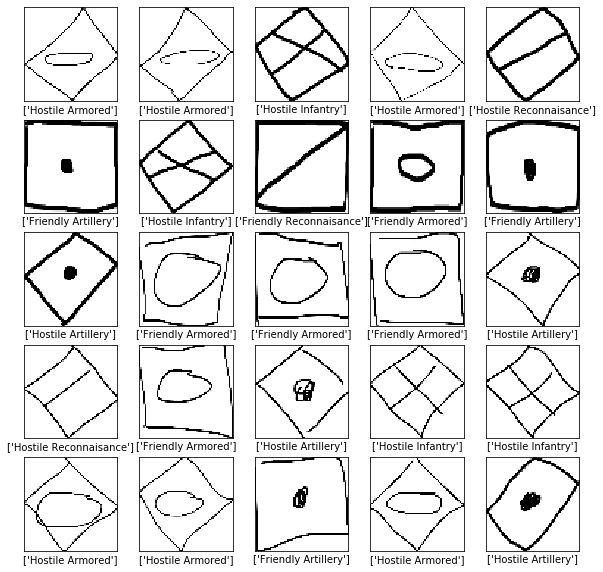

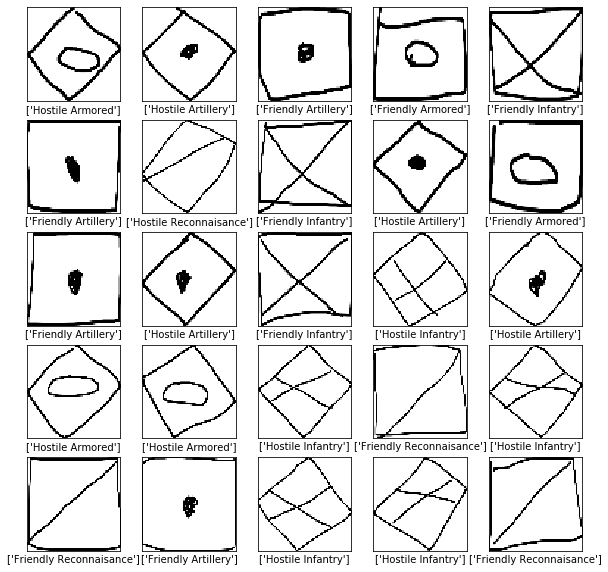

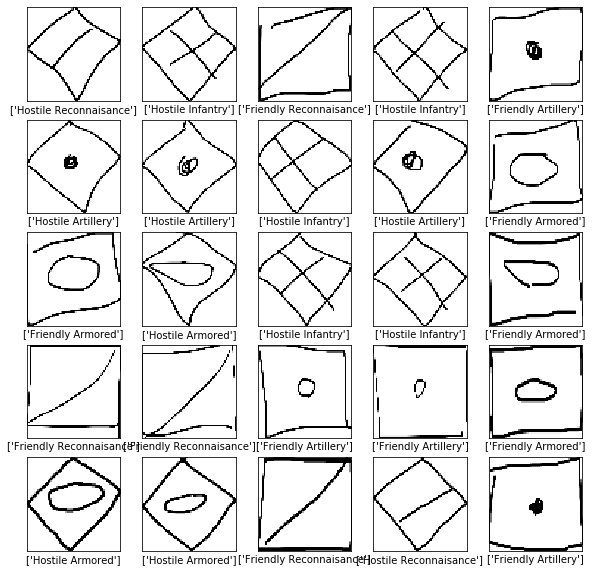

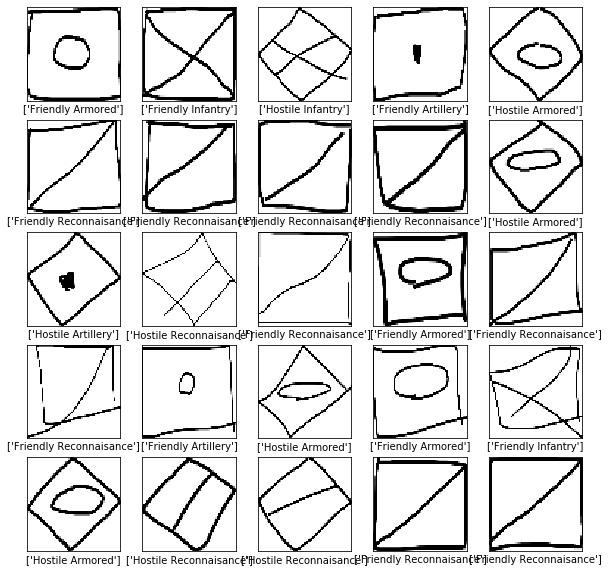

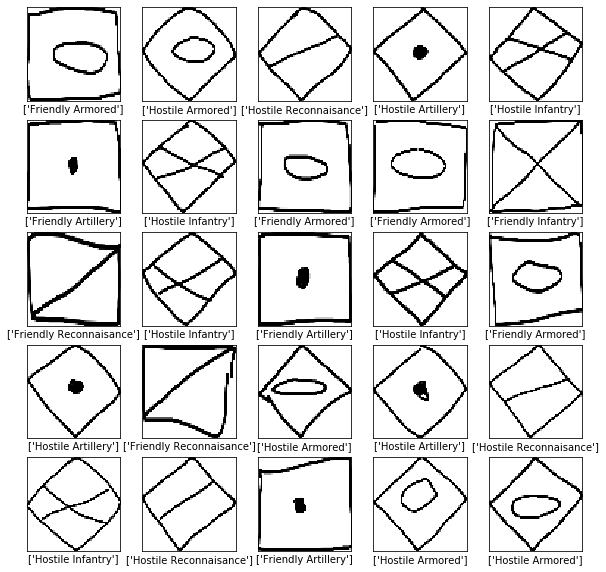

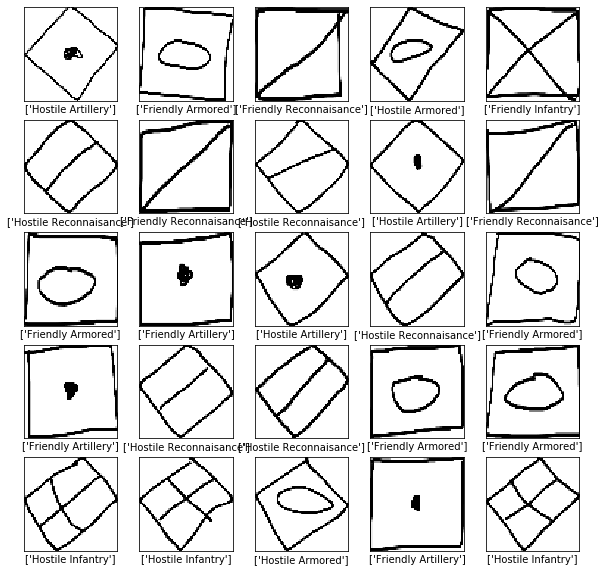

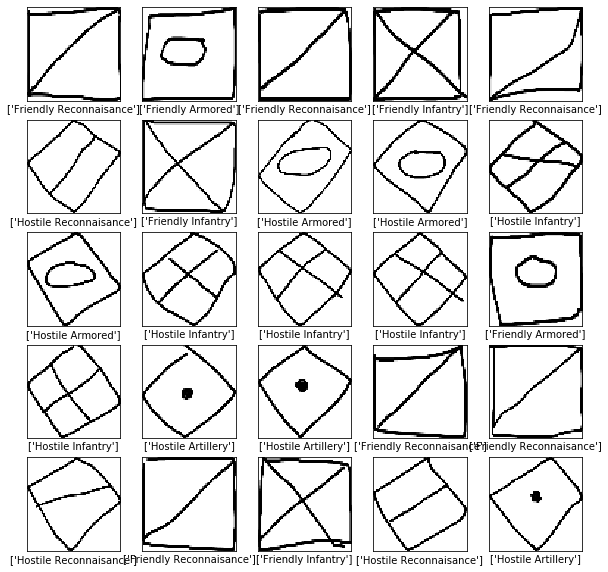

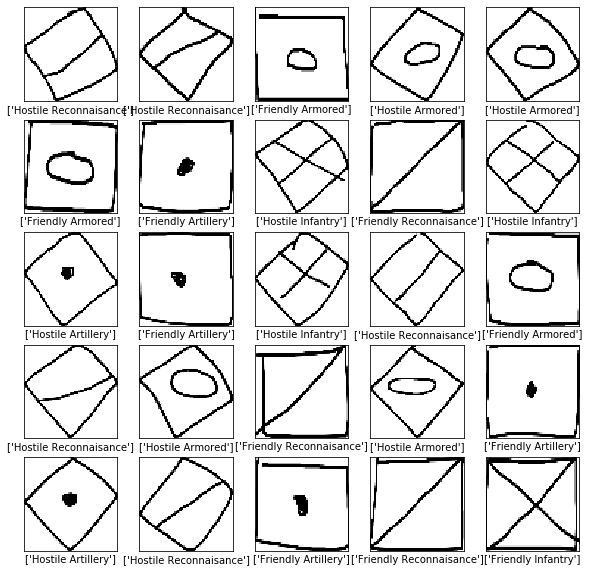

In [115]:
NUM_OF_PICS = 25

num_of_times = len(df['target']) // NUM_OF_PICS
counter = 0

# More visualization with matplotlib
for _ in range(num_of_times):
    plt.figure(figsize=(10,10))
    for i in range(NUM_OF_PICS):
        current_index = i+(counter*NUM_OF_PICS)
        plt.subplot(NUM_OF_PICS//5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(df['pixels'][current_index], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(df['label'][current_index])
    plt.show()
    counter += 1

In [116]:
TRAIN_TEST_SPLIT = len(df['pixels']) - 10

for i, array in enumerate(df['pixels']):
    df['pixels'][i] = np.reshape(array, df['pixels'][i].shape + (1,))

train_X, train_y = np.array([array for array in df['pixels'][:TRAIN_TEST_SPLIT]]), np.array([array for array in df['target'][:TRAIN_TEST_SPLIT]])
test_X, test_y = np.array([array for array in df['pixels'][TRAIN_TEST_SPLIT:]]), np.array([array for array in df['target'][TRAIN_TEST_SPLIT:]])

print(train_X.shape)
print(test_X.shape)

(192, 64, 64, 1)
(10, 64, 64, 1)


In [124]:
# Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(half_len_pixel_array, half_len_pixel_array, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(LABELS), activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [125]:
# Training
history = model.fit(train_X, train_y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_split=0.1)

Train on 172 samples, validate on 20 samples
Epoch 1/15
172/172 [==============================] - 1s 3ms/sample - loss: 2.0809 - acc: 0.1163 - val_loss: 2.0002 - val_acc: 0.4000
Epoch 2/15
172/172 [==============================] - 0s 2ms/sample - loss: 1.9807 - acc: 0.5116 - val_loss: 1.9199 - val_acc: 0.3500
Epoch 3/15
172/172 [==============================] - 0s 2ms/sample - loss: 1.8721 - acc: 0.5116 - val_loss: 1.8067 - val_acc: 0.4000
Epoch 4/15
172/172 [==============================] - 0s 2ms/sample - loss: 1.7232 - acc: 0.5174 - val_loss: 1.6632 - val_acc: 0.4500
Epoch 5/15
172/172 [==============================] - 0s 2ms/sample - loss: 1.5319 - acc: 0.6163 - val_loss: 1.4829 - val_acc: 0.5500
Epoch 6/15
172/172 [==============================] - 0s 2ms/sample - loss: 1.2973 - acc: 0.7791 - val_loss: 1.2563 - val_acc: 0.7000
Epoch 7/15
172/172 [==============================] - 0s 2ms/sample - loss: 1.0388 - acc: 0.8430 - val_loss: 1.0249 - val_acc: 0.6500
Epoch 8/15
172/17

10/10 - 0s - loss: 0.0510 - acc: 1.0000


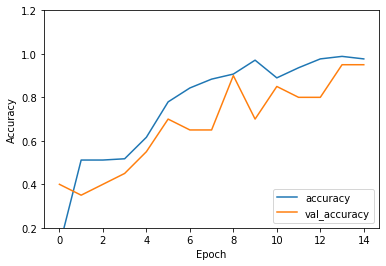

In [126]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.2])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_X, test_y, verbose=2)

The prediction of the drawing is: Friendly Reconnaisance
The actual label is: Friendly Reconnaisance - It's number is: 3


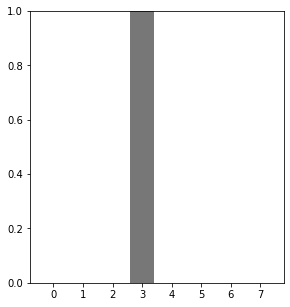

The prediction of the drawing is: Friendly Artillery
The actual label is: Friendly Artillery - It's number is: 1


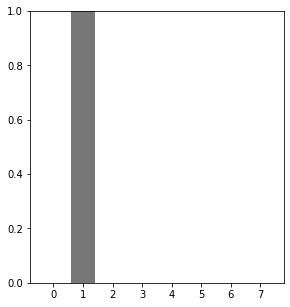

The prediction of the drawing is: Friendly Infantry
The actual label is: Friendly Infantry - It's number is: 2


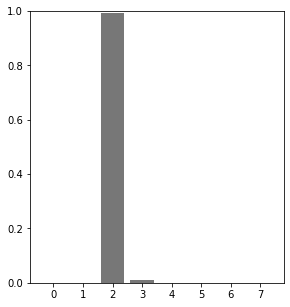

The prediction of the drawing is: Friendly Reconnaisance
The actual label is: Friendly Reconnaisance - It's number is: 3


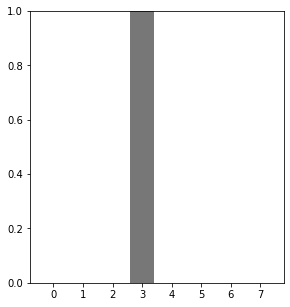

The prediction of the drawing is: Friendly Artillery
The actual label is: Friendly Artillery - It's number is: 1


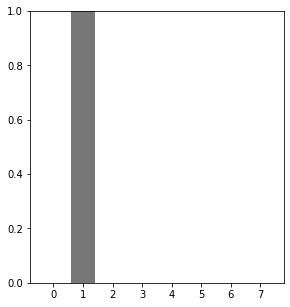

The prediction of the drawing is: Hostile Reconnaisance
The actual label is: Hostile Reconnaisance - It's number is: 7


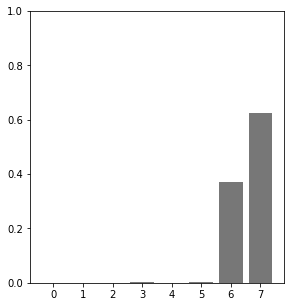

The prediction of the drawing is: Hostile Artillery
The actual label is: Hostile Artillery - It's number is: 5


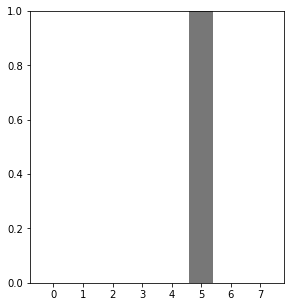

The prediction of the drawing is: Friendly Artillery
The actual label is: Friendly Artillery - It's number is: 1


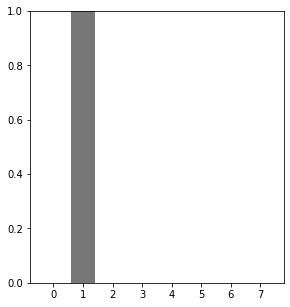

The prediction of the drawing is: Hostile Armored
The actual label is: Hostile Armored - It's number is: 4


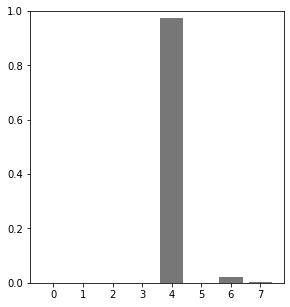

The prediction of the drawing is: Friendly Reconnaisance
The actual label is: Friendly Reconnaisance - It's number is: 3


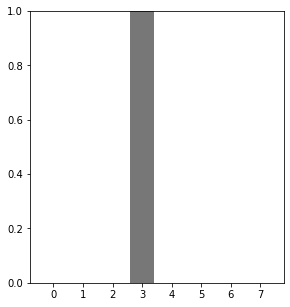

In [127]:
NUM_OF_PREDICTIONS = 10

for i in range(NUM_OF_PREDICTIONS):
    model_prediction = model.predict(np.array([test_X[-i-1]]))
    prediction = np.argmax(model_prediction)

    print(f"The prediction of the drawing is: {LABELS[prediction][1]}")
    print(f"The actual label is: {LABELS[test_y[-i-1]][1]} - It's number is: {test_y[-i-1]}")
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 2)
    plt.xticks([i for i in range(len(LABELS))])
    plt.bar(range(len(LABELS)), model_prediction[0][0:len(LABELS)], color="#777777")
    plt.ylim(0.0, 1.0)
    

    plt.show()

(4096,)


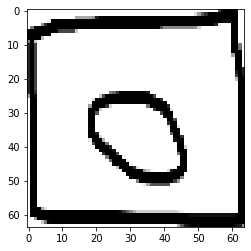

In [185]:
prediction_img = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183,255,255,255,255,244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,98,163,208,255,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86,86,86,86,86,108,222,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,18,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,243,237,237,255,255,0,0,0,0,0,0,114,207,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,217,24,0,0,0,255,255,0,0,0,135,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,252,171,118,118,118,118,118,118,118,118,118,110,47,1,0,0,0,0,0,0,0,0,255,255,0,0,249,255,255,255,255,255,255,255,255,185,185,185,185,185,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,255,255,255,255,255,255,252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,255,255,255,255,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,126,255,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,135,0,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,141,0,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,253,0,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,94,255,255,0,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,255,255,0,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,212,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,225,255,217,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,189,255,238,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66,255,255,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,217,255,189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,213,255,205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126,151,206,255,255,255,255,255,255,255,255,226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,97,255,243,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58,178,255,255,255,255,255,255,255,255,255,255,255,255,255,255,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,1,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,252,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,96,255,255,255,255,203,38,0,0,0,0,0,0,0,0,0,0,141,252,255,255,255,255,213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,246,255,255,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,191,255,255,255,255,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,169,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,185,255,255,254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,238,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,177,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,212,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,255,255,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,157,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,252,255,255,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,206,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,255,255,255,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,236,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,255,255,255,138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,254,255,255,255,215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,255,255,255,255,234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,245,255,254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,211,255,255,255,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,140,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,134,255,255,255,255,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,155,255,255,255,255,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,248,255,255,255,254,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,255,255,255,255,204,33,0,0,0,0,0,0,0,0,0,0,0,251,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,255,255,255,255,255,255,98,51,13,0,0,0,0,39,222,255,255,255,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,254,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,239,255,255,255,255,255,255,255,255,255,255,255,255,255,255,122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,125,255,255,255,255,255,255,255,255,255,255,195,101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,90,169,173,173,173,173,173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,255,86,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,244,198,160,121,82,50,50,50,50,50,50,50,50,50,50,50,50,33,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,247,240,237,237,237,237,237,237,237,237,237,237,237,237,255,255,255,0,0,104,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,0,0,0,0,53,138,250,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,80,162,225,238,253,255,255,255,255,255,255,255,255,255,255,255,255,234,221,109])
prediction_img = np.array([int(val) / 255 for val in prediction_img])

print(prediction_img.shape)
prediction_img = np.reshape(prediction_img, (-1, half_len_pixel_array))
plt.imshow(prediction_img, cmap=plt.cm.binary)
plt.show()

In [186]:
prediction_img = np.reshape(prediction_img, prediction_img. shape + (1,))
print(prediction_img.shape)

(64, 64, 1)


The prediction of the drawing is: Friendly Armored


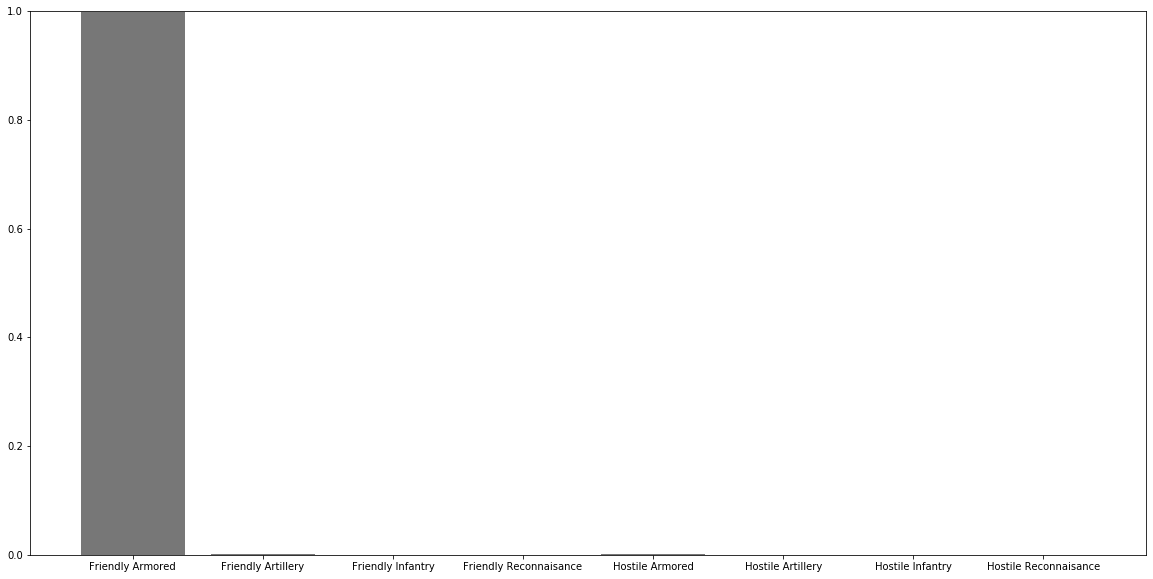

In [187]:
model_prediction = model.predict(np.array([prediction_img]))
prediction = np.argmax(model_prediction)

prediction = np.argmax(model_prediction)

print(f"The prediction of the drawing is: {LABELS[prediction][1]}")

fig, ax = plt.subplots(figsize=(20, 10))

fig.canvas.draw()

labels = [LABELS[i-1][1] for i in range(len(LABELS)+1)]
plt.bar(range(len(LABELS)), model_prediction[0][0:len(LABELS)], color="#777777")
ax.set_xticklabels(labels)
plt.ylim(0.0, 1.0)

plt.show()